# One dimensional convolutional networks

In this notebook we train several convolutional networks and evaluate their accuracy for the stated problem (classification of EEG signals).

In [1]:
%cd ..

/home/quentin/Documents/Courses/Deep learning/Projects/project1/src


In [2]:
import numpy as np

from utils.loading import load_data, save_obj, load_obj

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

%load_ext autoreload
%autoreload 2

from utils.cross_validation import early_stopping
from utils.cross_validation import cross_validation

from utils.visualization import plot_history

In [3]:
x_train, y_train = load_data(one_khz=False)
x_test, y_test = load_data(train=False, one_khz=False)

x_train_one_khz, y_train_one_khz = load_data(one_khz=True)
x_test_one_khz, y_test_one_khz = load_data(train=False, one_khz=True)

## Basic convolutional network with 1 convolution

We use this basic convolutional network with only one convolution to test hyper-parameters such as the learning rate or the type of optimizer. We evaluate the performances with cross validation and will further improve this model adding more layers or tricks such as dropout and batch normalization.

In [4]:
from conv_models import ConvNet1

### Training with the 100Hz sampled data

#### Cross validation over the learning rate

We first have to tune the learning rate with the `cross_validation` function.

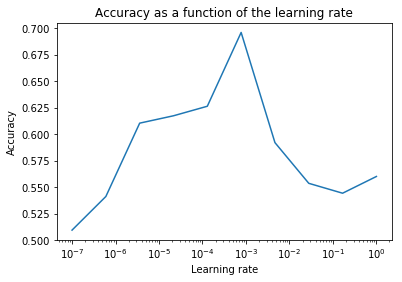

In [8]:
lr_list = np.logspace(-7, 0, 10)

acc_list = []
std_list = []

for lr in lr_list:
    acc, std = cross_validation(ConvNet1, x_train, y_train, epochs=1000, lr=lr)
    acc_list.append(acc)
    std_list.append(std)
    
plt.semilogx(lr_list, acc_list)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of the learning rate');

In [14]:
# /!\ Do not run unless you want to override it !
save_obj((acc_list, std_list), 'cross_val_lr')

In [7]:
acc_list, std_list = load_obj('cross_val_lr')
lr_tuned = lr_list[np.argmax(acc_list)]
print('The tuned learning rate is {}.'.format(round(lr_tuned, 6)))

The tuned learning rate is 0.000774.


#### Training the model

In [12]:
acc_list = cross_validation(lambda: ConvNet1(one_khz=False), x_train, y_train, raw=True, num_folds=10,
                            epochs=100, lr=lr_tuned, batch_size=16,
                            standardize=True, noise=False, crop=False)
acc = round(100*np.mean(acc_list), 4)
std = round(100*np.std(acc_list), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 76.5724+/-7.6311%


### Training with the 1kHZ sampled data

#### Cross validation over the learning rate

We first tune the learning rate here.

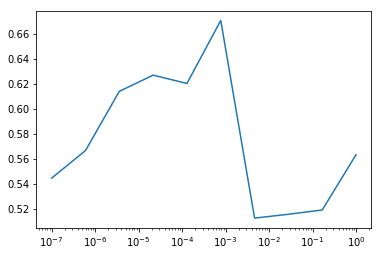

In [34]:
lr_list = np.logspace(-7, 0, 10)

acc_list = []
std_list = []

for lr in lr_list:
    acc, std = cross_validation(lambda: ConvNet1(one_khz=True),
                                x_train_one_khz, y_train_one_khz, epochs=1000, lr=lr)
    acc_list.append(acc)
    std_list.append(std)
    
plt.semilogx(lr_list, acc_list)

In [35]:
save_obj((acc_list, std_list), 'cross_val_lr_one_khz')

In [48]:
acc_list, std_list = load_obj('cross_val_lr_one_khz')
lr_tuned = lr_list[np.argmax(acc_list)]
print('The tuned learning rate is {}.'.format(round(lr_tuned, 6)))

The tuned learning rate is 0.000774.


#### Training the model

In [24]:
acc_list_one_khz = cross_validation(lambda: ConvNet1(one_khz=True), x_train_one_khz, y_train_one_khz,
                                    raw=True, num_folds=10,
                                    epochs=100, lr=lr_tuned, batch_size=16,
                                    standardize=True, noise=False, crop=False)
acc = round(100*np.mean(acc_list_one_khz), 4)
std = round(100*np.std(acc_list_one_khz), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 75.373+/-8.4727%


### Comparison of the results

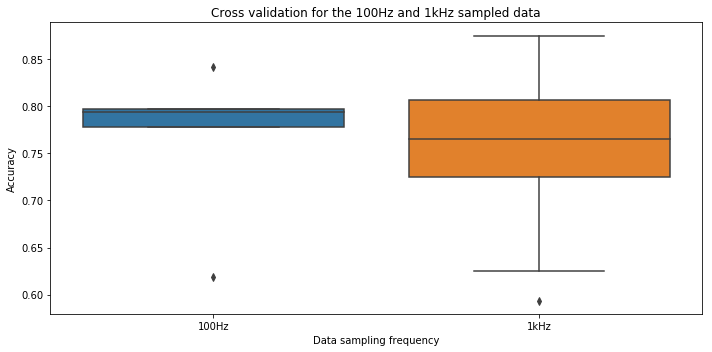

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=[acc_list, acc_list_one_khz], ax=ax)
ax.set_title('Cross validation for the 100Hz and 1kHz sampled data')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Data sampling frequency')
ax.set_xticklabels(['100Hz', '1kHz'], fontsize=10)

plt.tight_layout()

plt.show()

It seems like the 1kHz data set doesn't make the accuracy better ; it makes it even worse and we think that it comes from useless additional data points from which the network can't learn anything. Several models were trained on both the 100Hz and the 1kHz data, and it appears that the later doesn't improve the results. Thus, we decided to downsample from it and augment the 100Hz data this way. We do it using the `downsample` function defined in `utils.data_augmentation`. There are however several ways to downsample from the 1kHz data. On the one hand, we can pick 50 points regularly separated from the 500 original ones, so the size of the new data set is 10 times bigger. On the other hand, we can separate the sequence of length 500 in 50 intervals of length 10 and randomly pick one point in each of these intervals. In this case the separation is not regular but we can get a lot of more data ($10^{50}$).

**However, that data augmentation technique will only be used at the very end because we cannot use cross validation with it. Indeed, since the signals are often constant for long periods of time, a lot of the augmented data is similar and the cross validation results are biased (we get a validation accuracy very close to 100%). We however noticed that it improves the results on the test set.**

### Regularization to reduce overfitting

Let's plot here the learning curves : clearly, the model overfits. The validation loss starts increasing after only 20 epochs and the validation accuracy is stuck at ~75% while the train accuracy is almost 100%. We try here to add a dropout layer after the convolution to regularize the model and prevent this behavior.

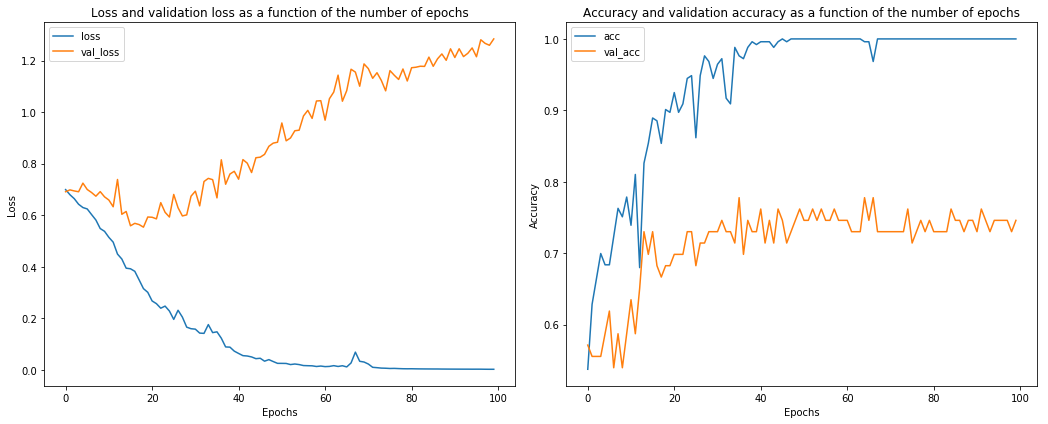

In [241]:
model = ConvNet1()
history = model.fit(x_train, y_train, validation_data=0.2, epochs=100, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=False, crop=False)
plot_history(history)

In [18]:
from conv_models import ConvNet1Dropout

In [17]:
acc_list_dropout = cross_validation(ConvNet1Dropout, x_train, y_train, raw=True, num_folds=10,
                                    epochs=100, lr=lr_tuned, batch_size=16,
                                    standardize=True, noise=False, crop=False)
acc = round(100*np.mean(acc_list_dropout), 4)
std = round(100*np.std(acc_list_dropout), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 79.1431+/-7.6394%


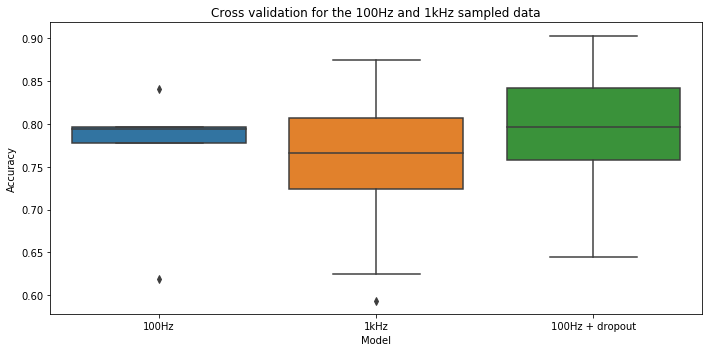

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=[acc_list, acc_list_one_khz, acc_list_dropout], ax=ax)
ax.set_title('Cross validation for the 100Hz and 1kHz sampled data')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_xticklabels(['100Hz', '1kHz', '100Hz + dropout'], fontsize=10)

plt.tight_layout()

plt.show()

It seems to slightly improve the accuracy but the variable is also very high (~7.7). We can also check that the model still overfits :

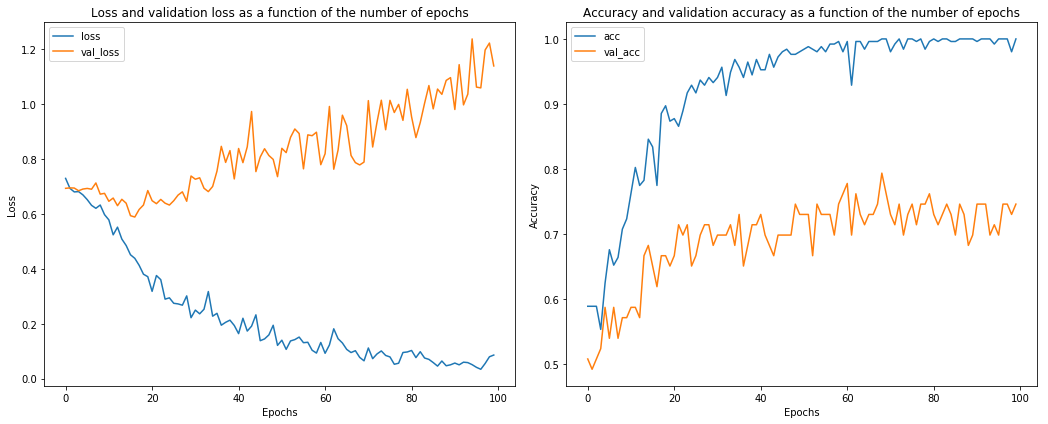

In [245]:
model = ConvNet1Dropout()
history = model.fit(x_train, y_train, validation_data=0.2, epochs=100, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=False, crop=False)
plot_history(history)

### Augmenting the data

Besides the downsampling method presented previously, we found two other ways to augment the data. First, a gaussian noise can be added to the data. Secondly, it is possible to randomly crop a window of size say 42 in the sequence of length 50. The resulting data size would thus be $28\times32$. When some new data is predicted, it also has to be cropped. Since some information is lost, we decided to crop randomly the same data several times (say 11), predict a label for each crop, and finally make a poll for the final label.

In both cases, the data is augmented dynamically through the training process : when a data point is considered, a `GaussianNoise` or a `Crop1d` transformation is applied to it.

#### Adding noise to the data

Cross validation to find the right noise standard deviation.

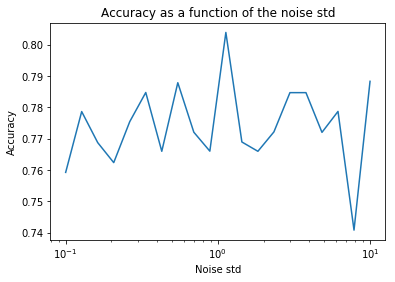

In [14]:
noise_std_list = np.logspace(-1, 1, 20)

acc_list = []
std_list = []

for noise_std in noise_std_list:
    acc, std = cross_validation(ConvNet1Dropout, x_train, y_train, epochs=200, lr=lr_tuned, batch_size=16,
                                standardize=True, noise=noise_std, crop=False)
    acc_list.append(acc)
    std_list.append(std)
    
plt.semilogx(noise_std_list, acc_list)
plt.xlabel('Noise std')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of the noise std');

In [11]:
save_obj((acc_list, std_list), 'cross_val_noise')

In [13]:
acc_list, std_list = load_obj('cross_val_noise')
noise_tuned = noise_std_list[np.argmax(acc_list)]
print('The tuned noise std is {}.'.format(round(noise_tuned, 3)))

The tuned noise std is 1.129.


In [33]:
acc_list_noise = cross_validation(ConvNet1Dropout, x_train, y_train, raw=True, num_folds=10,
                                  epochs=100, lr=lr_tuned, batch_size=16,
                                  standardize=True, noise=noise_tuned, crop=False)
acc = round(100*np.mean(acc_list_noise), 4)
std = round(100*np.std(acc_list_noise), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 81.3004+/-4.6981%


It seems to slightly improve the results, but more importantly : it decreases the standard deviation which was very high for the last model.

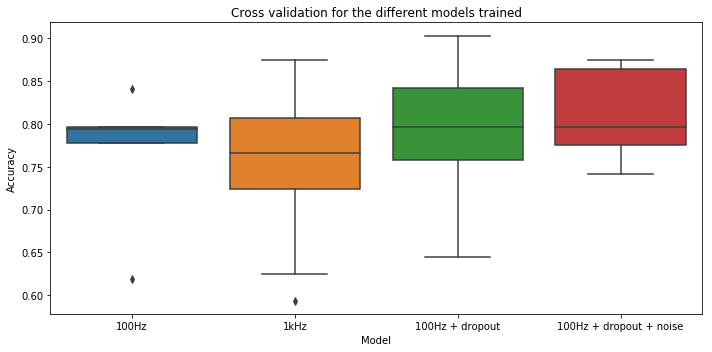

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=[acc_list, acc_list_one_khz, acc_list_dropout, acc_list_noise], ax=ax)
ax.set_title('Cross validation for the different models trained')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_xticklabels(['100Hz', '1kHz', '100Hz + dropout', '100Hz + dropout + noise'], fontsize=10)

plt.tight_layout()

plt.show()

#### Cropping the data

In [35]:
from conv_models import ConvNet1DropoutCrop42

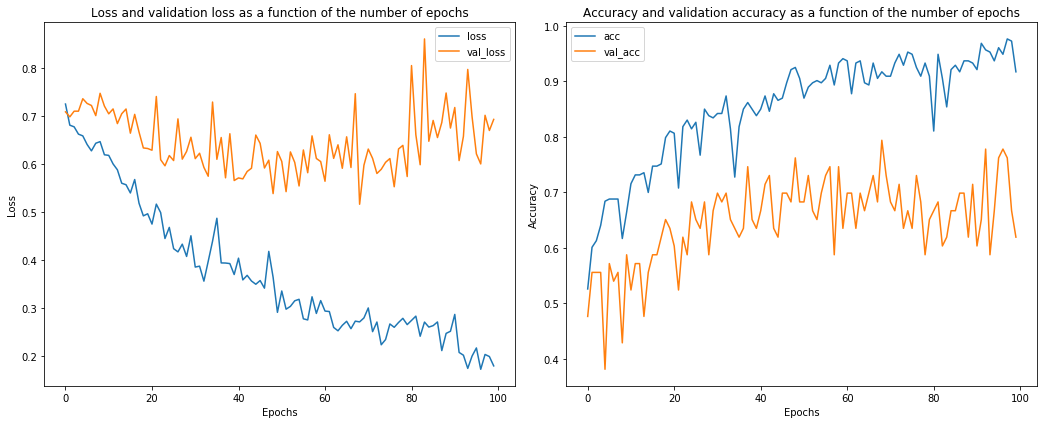

In [370]:
model = ConvNet1DropoutCrop42()
history = model.fit(x_train, y_train, validation_data=0.2, epochs=100, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=noise_tuned, crop=42)
plot_history(history)

In [37]:
acc_list_crop = cross_validation(ConvNet1DropoutCrop42, x_train, y_train, raw=True, num_folds=10,
                                 epochs=150, lr=lr_tuned, batch_size=16,
                                  standardize=True, noise=noise_tuned, crop=42)
acc = round(100*np.mean(acc_list_crop), 4)
std = round(100*np.std(acc_list_crop), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 74.375+/-9.6612%


It seems like the cropping decreases the accuracy. We remove it for the next models.

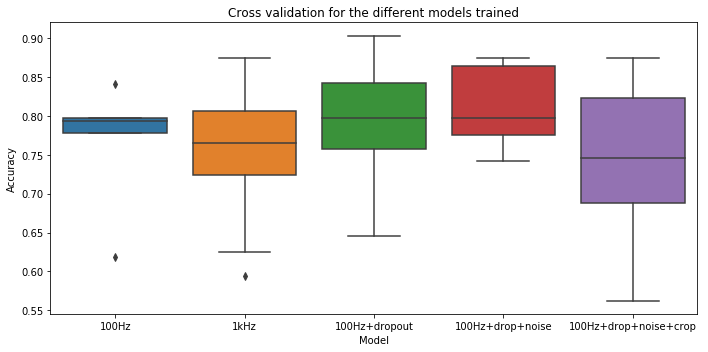

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=[acc_list, acc_list_one_khz, acc_list_dropout, acc_list_noise, acc_list_crop], ax=ax)
ax.set_title('Cross validation for the different models trained')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_xticklabels(['100Hz', '1kHz', '100Hz+dropout',
                    '100Hz+drop+noise',
                    '100Hz+drop+noise+crop'],
                   fontsize=10)

plt.tight_layout()

plt.show()

#### Adaptative learning rate

The learning rate decay stabilizes the learning curve and the model takes longer to overfit as the two following plots show :

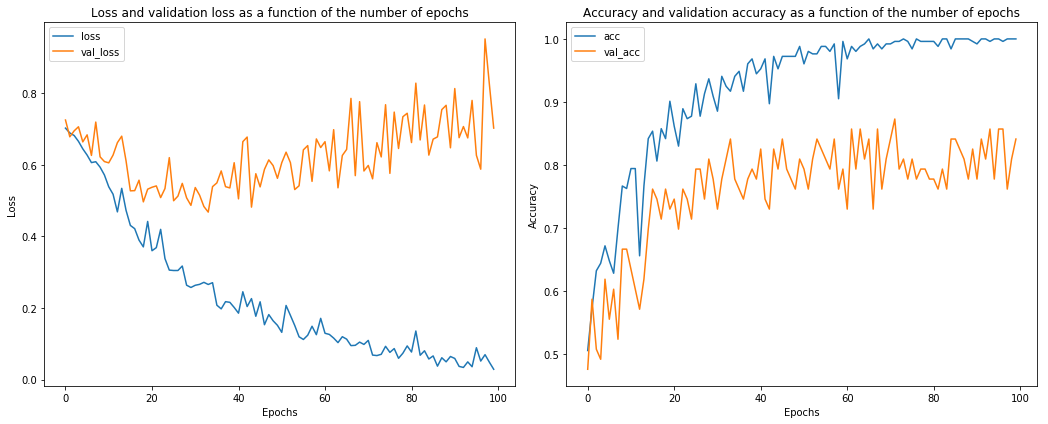

In [293]:
model = ConvNet1Dropout()
history = model.fit(x_train, y_train, validation_data=0.2, epochs=100, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=noise_tuned, crop=False)
plot_history(history)

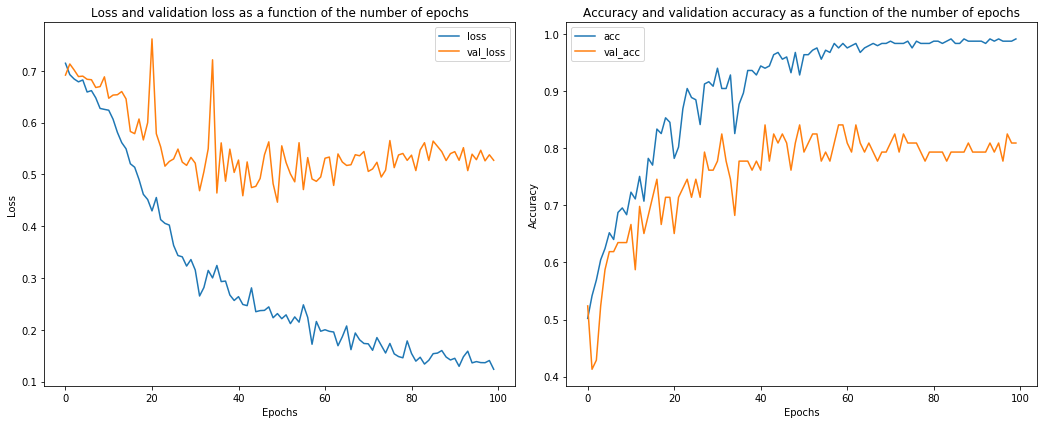

In [295]:
model = ConvNet1Dropout()
history = model.fit(x_train, y_train, validation_data=0.2, epochs=100, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=noise_tuned, crop=False, lr_decay=(10, 0.8))
plot_history(history)

## Adding more layers

We try here to improve the model by adding more layers.

### Using two convolutions

In [40]:
from conv_models import ConvNet2

Let's first see after how many epochs the model overfits.

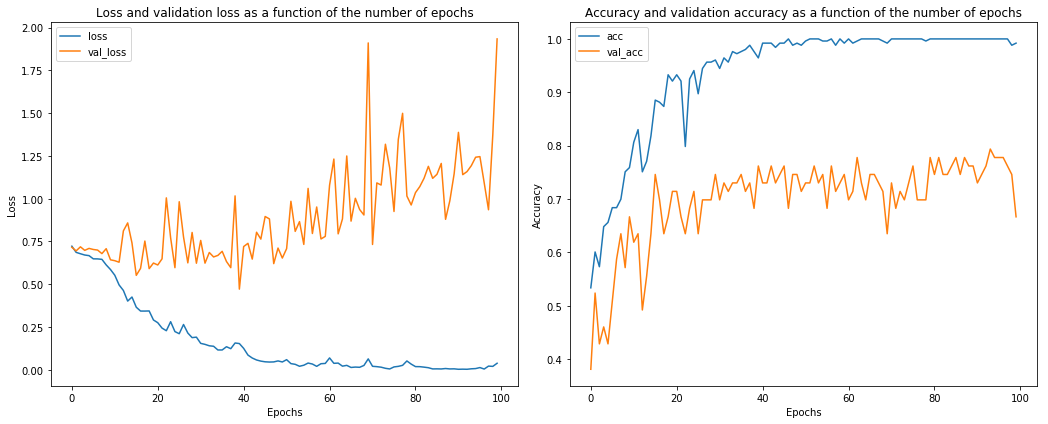

In [8]:
model = ConvNet2()
history = model.fit(x_train, y_train, validation_data=0.2, epochs=100, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=noise_tuned, crop=False)
plot_history(history)

In [42]:
acc_list_22 = cross_validation(ConvNet2, x_train, y_train, raw=True, num_folds=10,
                              epochs=100, lr=lr_tuned, batch_size=16,
                              standardize=True, noise=noise_tuned, crop=False, lr_decay=(10, 0.8))
acc = round(100*np.mean(acc_list_2), 4)
std = round(100*np.std(acc_list_2), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 80.0504+/-4.902%


### Convolutional network with 3 convolutions

In [5]:
from conv_models import ConvNet3

In [8]:
acc_list_33 = cross_validation(ConvNet3, x_train, y_train, raw=True, num_folds=10,
                              epochs=500, lr=lr_tuned, batch_size=16,
                              standardize=True, noise=noise_tuned, crop=False, lr_decay=(10, 0.8))
acc = round(100*np.mean(acc_list_33), 4)
std = round(100*np.std(acc_list_33), 4)
print('The accuracy of this model is {0}+/-{1}%'.format(acc, std))

The accuracy of this model is 81.0585+/-6.7535%


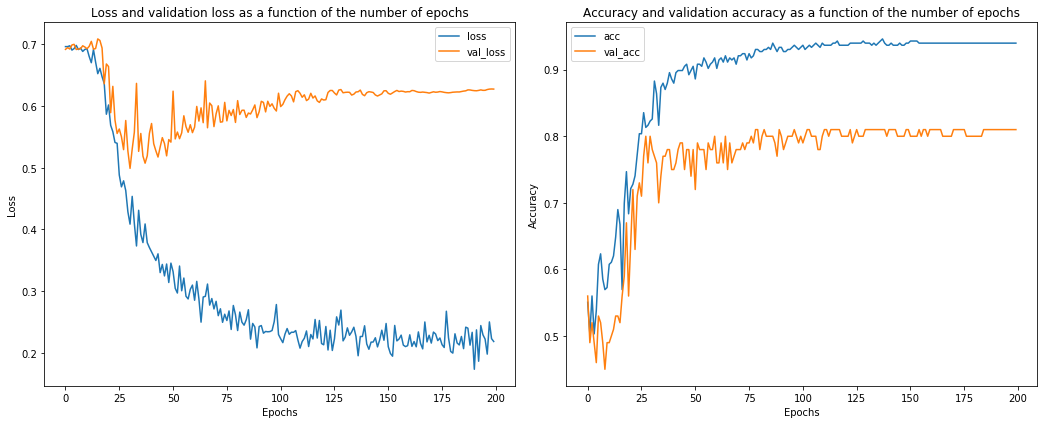

In [10]:
model = ConvNet3()
history = model.fit(x_train, y_train, x_test, y_test, epochs=200, lr=lr_tuned, batch_size=16,
                    standardize=True, noise=noise_tuned, crop=False, lr_decay=(10, 0.7))
plot_history(history)

In [11]:
early_stopping(history)

(0.4084948614239693, 0.4989165961742401, 0.8259493670886076, 0.78)

## Two-dimensional convolution

In [23]:
from conv_models import ConvNet2d

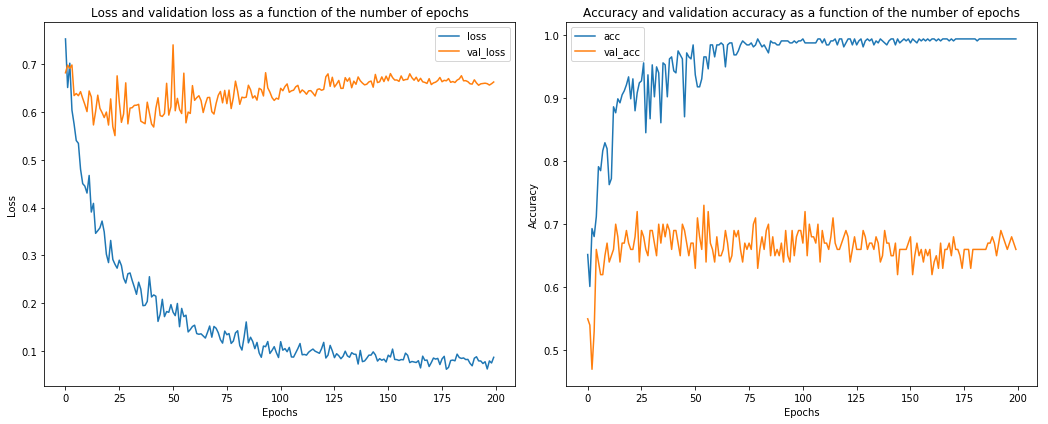

In [26]:
model = ConvNet2d()
lr_tuned = 0.000777
noise_tuned = 1.1
history = model.fit(x_train, y_train, x_test, y_test, epochs=200, lr=lr_tuned, batch_size=16,
              standardize=True, noise=noise_tuned, crop=False, lr_decay=(10, 0.8))
plot_history(history)

## Plot with the test set

In [12]:
from utils.data_augmentation import downsample

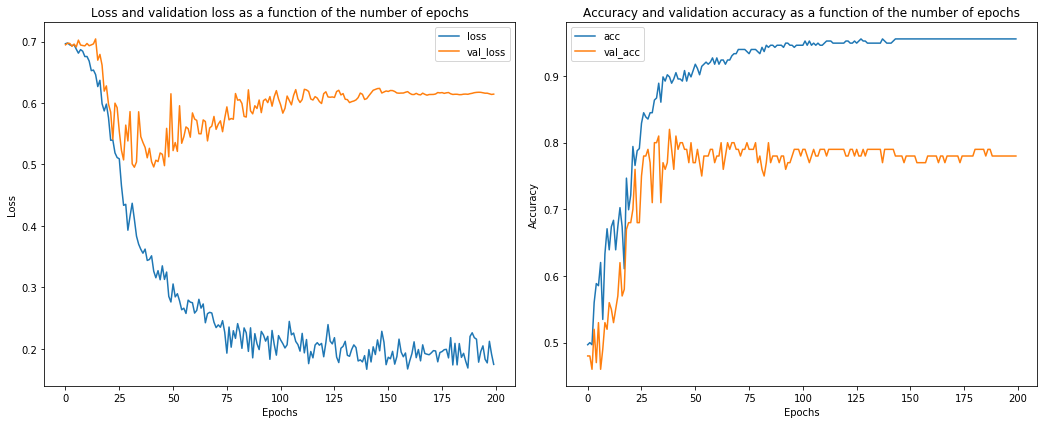

In [51]:
model = ConvNet3()
history = model.fit(x_train, y_train, x_test, y_test, epochs=200, lr=lr_tuned,
                    batch_size=16, standardize=True, noise=noise_tuned, crop=False, lr_decay=(10, 0.7))
plot_history(history)

In [52]:
early_stopping(history)

(0.41103389859199524, 0.49550843238830566, 0.8670886075949367, 0.8)

In [13]:
x_train_downsampled, y_train_downsampled = downsample(x_train_one_khz, y_train_one_khz)

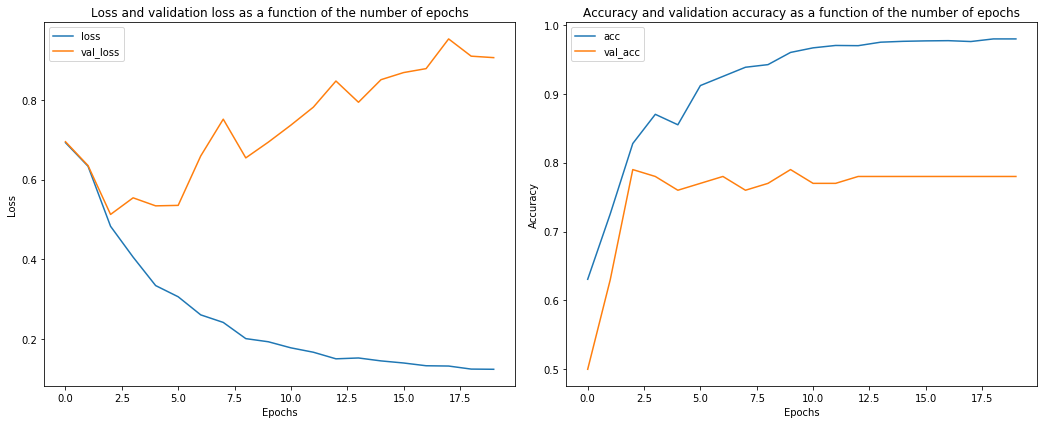

In [55]:
model = ConvNet3()
history = model.fit(x_train_downsampled, y_train_downsampled, x_test, y_test, epochs=20, lr=lr_tuned,
                    batch_size=16, standardize=True, noise=noise_tuned, crop=False, lr_decay=(1, 0.8))
plot_history(history)

In [56]:
early_stopping(history)

(0.48278002583920354, 0.5125863552093506, 0.8278481012658228, 0.79)